In [1]:
import gc
import os
import re
import argparse

import torch
import wandb
from datasets import load_dataset
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)
from trl import ORPOConfig, ORPOTrainer, setup_chat_format
from lm_eval import evaluator, tasks
from lm_eval.models.huggingface import HFLM

# api_key="MY_WANDB_API_KEY" # WANDB API KEY
# wandb.login(key=api_key)
# wandb.init(project='assignment-edgerunner-aris')

# Set torch dtype and attention implementation
if torch.cuda.get_device_capability()[0] >= 8:
    !pip install -qqq flash-attn
    torch_dtype = torch.bfloat16
    attn_implementation = "flash_attention_2"
else:
    torch_dtype = torch.float16
    attn_implementation = "eager"
    
# BNB config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=True,
)

# LoRA config
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)

model1_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model2_name = "edgerunner-ai/EdgeRunner-Tactical-7B"
tuned_model1_name = "ORPO-Llama-3.1-8B-Instruct-GSM8K"
tuned_model2_name = "ORPO-EdgeRunner-Tactical-7B-GSM8K"

/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-15 23:43:19.854931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 23:43:19.854988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 23:43:19.856224: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 23:43:19.863795: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow b

#### Model 1 (Llama 3.1) Evaluation GSM8K ####

In [3]:
try:
    del model2
    torch.cuda.empty_cache()
    gc.collect()
except:
    torch.cuda.empty_cache()
    gc.collect()
    
def evaluate_model(model, task="gsm8k"):
    print(f"Task: {task}")
    
    results = evaluator.simple_evaluate(
        model="hf",
        model_args=f"pretrained={model},load_in_4bit=True",
        tasks=[task],
        batch_size='auto',
        device='auto',
        #limit = 10,
        num_fewshot = 8, # for paper
        apply_chat_template=True,
        fewshot_as_multiturn=True
    )
    
    return results

task = 'gsm8k'
results = evaluate_model(model1_name, task)
print(results['results'])

Task: gsm8k


2024-09-16:04:23:35,445 INFO     [evaluator.py:161] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234
2024-09-16:04:23:35,445 INFO     [evaluator.py:198] Initializing hf model, with arguments: {'pretrained': 'meta-llama/Meta-Llama-3.1-8B-Instruct', 'load_in_4bit': True}
2024-09-16:04:23:35,447 INFO     [huggingface.py:138] Device not specified
2024-09-16:04:23:35,447 INFO     [huggingface.py:139] Cuda Available? True
2024-09-16:04:23:35,799 INFO     [huggingface.py:366] Model parallel was set to False, max memory was not set, and device map was set to {'': 'cuda'}
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]
2024-09-16:04:23:40,900 WARNING  [big_modeling.py:451] You shouldn't move a model that is dispatched using accelerate hooks

Passed argument batch_size = auto. Detecting largest batch size


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Determined Largest batch size: 1


/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Running generate_until requests: 100%|██████████| 1319/1319 [3:14:08<00:00,  8.83s/it] 
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the

{'gsm8k': {'alias': 'gsm8k', 'exact_match,strict-match': 0.7543593631539045, 'exact_match_stderr,strict-match': 0.011857183603902225, 'exact_match,flexible-extract': 0.7702805155420773, 'exact_match_stderr,flexible-extract': 0.011586857544997503}}


#### Model 2 (EdgeRunner Tactical) Evaluation GSM8K ####

In [2]:
try:
    del model1
    torch.cuda.empty_cache()
    gc.collect()
except:
    torch.cuda.empty_cache()
    gc.collect()


# EdgeRunner-Tactical-7B does not fit into the GPU in this compute instance.
# So I will load it in 4bit precision. However, evaluation in this quantized model might not be accurate,
# since when loading and using the model with this configuration it produced incoherent text jargon.
def evaluate_model(model, task="gsm8k"):
    print(f"Task: {task}")
    
    results = evaluator.simple_evaluate(
        model="hf",
        model_args=f"pretrained={model},load_in_4bit=True",
        tasks=[task],
        batch_size='auto',
        device='auto',
        #limit = 10,
        num_fewshot = 8, # 8 for paper
        apply_chat_template=True,
        fewshot_as_multiturn=True
    )
    
    return results

task = 'gsm8k'
results = evaluate_model(model2_name, task)
print(results['results'])

# Flush memory
try:
    del model2
    torch.cuda.empty_cache()
    gc.collect()
except:
    torch.cuda.empty_cache()
    gc.collect()

2024-09-15:23:43:30,646 INFO     [evaluator.py:161] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234
2024-09-15:23:43:30,647 INFO     [evaluator.py:198] Initializing hf model, with arguments: {'pretrained': 'edgerunner-ai/EdgeRunner-Tactical-7B', 'load_in_4bit': True}
2024-09-15:23:43:30,715 INFO     [huggingface.py:138] Device not specified
2024-09-15:23:43:30,716 INFO     [huggingface.py:139] Cuda Available? True


Task: gsm8k


2024-09-15:23:43:31,115 INFO     [huggingface.py:366] Model parallel was set to False, max memory was not set, and device map was set to {'': 'cuda'}
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]
2024-09-15:23:43:40,763 WARNING  [big_modeling.py:451] You shouldn't move a model that is dispatched using accelerate hooks.
2024-09-15:23:43:41,317 INFO     [__init__.py:491] `group` and `group_alias` keys in TaskConfigs are deprecated and will be removed in v0.4.5 of lm_eval. The new `tag` field will be used to allow for a shortcut to a group of tasks one does not wish to aggregate metrics across. `group`s which aggregate across subtasks must be only defined in a separate group config file, which will be the official way to create groups that support cross-task aggregation as

Passed argument batch_size = auto. Detecting largest batch size
Determined Largest batch size: 1


/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:589: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Running generate_until requests: 10

{'gsm8k': {'alias': 'gsm8k', 'exact_match,strict-match': 0.012130401819560273, 'exact_match_stderr,strict-match': 0.0030152942428909504, 'exact_match,flexible-extract': 0.6338134950720242, 'exact_match_stderr,flexible-extract': 0.01327010023874883}}


#### Model 1 (Llama 3.1) Fine-Tune ORPO ####

In [3]:
model1 = AutoModelForCausalLM.from_pretrained(model1_name, 
                                              quantization_config=bnb_config,
                                              attn_implementation=attn_implementation,
                                              device_map="auto", cache_dir = './models/')
tokenizer1 = AutoTokenizer.from_pretrained(model1_name)
# tokenizer1.pad_token = tokenizer1.eos_token
model1, tokenizer1 = setup_chat_format(model1, tokenizer1)                                             
model1 = prepare_model_for_kbit_training(model1)


dataset_name = "mlabonne/orpo-dpo-mix-40k"
dataset = load_dataset(dataset_name, split="all")
dataset = dataset.shuffle(seed=1234).select(range(2000)) # Only use some samples for assignment time & resources constraints

def format_chat_template(row):
    row["chosen"] = tokenizer1.apply_chat_template(row["chosen"], tokenize=False)
    row["rejected"] = tokenizer1.apply_chat_template(row["rejected"], tokenize=False)
    return row

dataset = dataset.map(
    format_chat_template,
    num_proc= os.cpu_count(),
)
dataset = dataset.train_test_split(test_size=0.01)

Loading checkpoint shards: 100%|██████████| 4/4 [01:07<00:00, 16.78s/it]


In [4]:
orpo_args = ORPOConfig(
    learning_rate=8e-6,
    lr_scheduler_type="linear",
    max_length=1024,
    max_prompt_length=512,
    beta=0.1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    optim="paged_adamw_8bit",
    num_train_epochs=1, # Just 1 epoch for the assignment
    evaluation_strategy="steps",
    eval_steps=0.2,
    logging_steps=1,
    warmup_steps=10,
    report_to="wandb",
    output_dir="./results/",
    seed = 1234
)

trainer = ORPOTrainer(
    model=model1,
    args=orpo_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    peft_config=peft_config,
    tokenizer=tokenizer1,
)

trainer.train()

# Save adapters after training
trainer.model.save_pretrained("./Llama_FT_Adapters/")
tokenizer1.save_pretrained("./Llama_FT_Adapters/")


/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/trl/trainer/orpo_trainer.py:255: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(
Map: 100%|██████████| 20/20 [00:00<00:00, 214.11 examples/s]
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be p

Step,Training Loss,Validation Loss,Runtime,Samples Per Second,Steps Per Second,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen,Nll Loss,Log Odds Ratio,Log Odds Chosen
99,1.185100,1.170097,34.660700,0.577000,0.577000,-0.080159,-0.081189,0.500000,0.001031,-0.811894,-0.801589,-1.192466,-0.760882,1.101702,-0.683950,0.084238
198,1.158200,1.067999,34.634200,0.577000,0.577000,-0.070551,-0.070821,0.500000,0.000271,-0.708212,-0.705506,-0.739886,-0.458917,0.999316,-0.686829,0.097613
297,0.938800,1.032679,34.633500,0.577000,0.577000,-0.068220,-0.071094,0.550000,0.002874,-0.710940,-0.682201,-0.630925,-0.364262,0.967068,-0.656107,0.173828
396,0.980000,1.021572,34.634800,0.577000,0.577000,-0.067609,-0.071633,0.600000,0.004024,-0.716327,-0.676089,-0.549493,-0.308409,0.957033,-0.645399,0.202548
495,1.230800,1.018366,34.633200,0.577000,0.577000,-0.067445,-0.072256,0.600000,0.004811,-0.722560,-0.674452,-0.535899,-0.299210,0.954504,-0.638618,0.220906


/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


('./Llama_FT_Adapters/tokenizer_config.json',
 './Llama_FT_Adapters/special_tokens_map.json',
 './Llama_FT_Adapters/tokenizer.json')

In [5]:
# Flush memory
try:
    del model1
    torch.cuda.empty_cache()
    gc.collect()
except:
    torch.cuda.empty_cache()
    gc.collect()
    
# Reload tokenizer and model
tokenizer1 = AutoTokenizer.from_pretrained(model1_name)
model1 = AutoModelForCausalLM.from_pretrained(
    model1_name,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation=attn_implementation,
)
model1, tokenizer1 = setup_chat_format(model1, tokenizer1)

# Merge adapter with base model
merged_model = PeftModel.from_pretrained(model1, "./Llama_FT_Adapters/")
merged_model = merged_model.merge_and_unload()

# Save model and tokenizer
merged_model.save_pretrained(tuned_model1_name)
tokenizer1.save_pretrained(tuned_model1_name)

# Push tuned model to HF
merged_model.push_to_hub(tuned_model1_name, use_temp_dir=True, token = "") # write HF token
tokenizer1.push_to_hub(tuned_model1_name, use_temp_dir=True, token = "") # write HF token


Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]
/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/peft/tuners/lora/bnb.py:336: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s].05G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]
model-00002-of-00002.safetensors:   0%|          | 4.06M/1.05G [00:00<00:25, 40.6MB/s]

model-00001-of-00002.safetensors:   0%|          | 3.51M/4.65G [00:00<02:12, 35.0MB/s]
model-00002-of-00002.safetensors:   2%|▏         | 16.0M/1.05G [00:00<00:19, 54.2MB/s]

model-00001-of-00002.safetensors:   0%|          | 16.0M/4.65G [00:00<01:30, 51.2MB/s]

model-00001-of-00002.safetensors:   1%|          | 32.0M/4.65G [00:00<01:08, 67.9MB/s]
model-00002-of-00002.safetensors:   3%|▎         | 32.0M/1.05G [00:00<00:16, 62.1MB/s]
model-00002-of-00002.safetensors:  

CommitInfo(commit_url='https://huggingface.co/huggingscientist10/ORPO-Llama-3.1-8B-Instruct-GSM8K/commit/e1ca7c943c750c0d2ded3ac35d9331c53b21661d', commit_message='Upload tokenizer', commit_description='', oid='e1ca7c943c750c0d2ded3ac35d9331c53b21661d', pr_url=None, pr_revision=None, pr_num=None)

#### Model 2 (EdgeRunner Tactical) Fine-Tune ORPO ####

In [2]:
# Flush memory
try:
    del model1
    del merged_model
    del trainer
    torch.cuda.empty_cache()
    gc.collect()
except:
    torch.cuda.empty_cache()
    gc.collect()
    
# Initialize Model 2/EdgeRunner Tactical
model2 = AutoModelForCausalLM.from_pretrained(model2_name,attn_implementation=attn_implementation,
                torch_dtype=torch.bfloat16, device_map="auto", cache_dir = './models/')
tokenizer2 = AutoTokenizer.from_pretrained(model2_name)
    
dataset_name = "mlabonne/orpo-dpo-mix-40k"
dataset = load_dataset(dataset_name, split="all")
dataset = dataset.shuffle(seed=1234).select(range(2000)) # Only use 1000 samples for quick demo

def format_chat_template(row):
    row["chosen"] = tokenizer2.apply_chat_template(row["chosen"], tokenize=False)
    row["rejected"] = tokenizer2.apply_chat_template(row["rejected"], tokenize=False)
    return row

dataset = dataset.map(
    format_chat_template,
    num_proc= os.cpu_count(),
)
dataset = dataset.train_test_split(test_size=0.01) # Re-split dataset since the chat template formating removed train/test split.

Loading checkpoint shards: 100%|██████████| 7/7 [02:09<00:00, 18.56s/it]


In [4]:
orpo_args = ORPOConfig(
    learning_rate=8e-6,
    lr_scheduler_type="linear",
    max_length=1024,
    max_prompt_length=512,
    beta=0.1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    optim="paged_adamw_8bit",
    num_train_epochs=1,
    evaluation_strategy="steps",
    eval_steps=0.2,
    logging_steps=1,
    warmup_steps=10,
    report_to="wandb",
    output_dir="./results/",
    seed = 1234
)

trainer = ORPOTrainer(
    model=model2,
    args=orpo_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    peft_config=peft_config,
    tokenizer=tokenizer2,
)
trainer.train()
trainer.model.save_pretrained("./EdgeRunner_FT_Adapters/")
tokenizer2.save_pretrained("./EdgeRunner_FT_Adapters/")

/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.9/site-packages/trl/trainer/orpo_trainer.py:255: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(
Map: 100%|██████████| 20/20 [00:00<00:00, 140.96 examples/s]
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Runtime,Samples Per Second,Steps Per Second,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen,Nll Loss,Log Odds Ratio,Log Odds Chosen
99,0.941700,1.262900,37.682100,0.531000,0.531000,-0.100109,-0.104098,0.500000,0.003989,-1.040976,-1.001090,-1.526038,-0.868249,1.193946,-0.689545,0.056690
198,1.039800,1.134898,37.672200,0.531000,0.531000,-0.085545,-0.084231,0.450000,-0.001314,-0.842309,-0.855447,-1.520530,-0.849269,1.063321,-0.715768,-0.005385
297,1.060400,1.104771,37.651100,0.531000,0.531000,-0.082312,-0.080231,0.450000,-0.002081,-0.802306,-0.823116,-1.531466,-0.871727,1.032694,-0.720779,-0.015191
396,1.117000,1.091131,37.652900,0.531000,0.531000,-0.080975,-0.078231,0.450000,-0.002744,-0.782310,-0.809751,-1.530538,-0.872586,1.018570,-0.725612,-0.023911
495,0.910900,1.086137,37.658600,0.531000,0.531000,-0.080373,-0.077437,0.500000,-0.002936,-0.774367,-0.803728,-1.529951,-0.874795,1.013409,-0.727286,-0.026317


('./EdgeRunner_FT_Adapters/tokenizer_config.json',
 './EdgeRunner_FT_Adapters/special_tokens_map.json',
 './EdgeRunner_FT_Adapters/vocab.json',
 './EdgeRunner_FT_Adapters/merges.txt',
 './EdgeRunner_FT_Adapters/added_tokens.json',
 './EdgeRunner_FT_Adapters/tokenizer.json')

In [ ]:
# Flush memory
try:
    del model2
    torch.cuda.empty_cache()
    gc.collect()
except:
    torch.cuda.empty_cache()
    gc.collect()
    
# Reload tokenizer and model
tokenizer2 = AutoTokenizer.from_pretrained(model2_name)
model2 = AutoModelForCausalLM.from_pretrained(
    model2_name,
    return_dict=True,
    # quantization_config=bnb_config, # 4-bit breaks model text generation in this model
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation=attn_implementation,
)
model2, tokenizer2 = setup_chat_format(model2, tokenizer2)

# Merge adapter with base model
merged_model = PeftModel.from_pretrained(model2, "./EdgeRunner_FT_Adapters/")
merged_model = merged_model.merge_and_unload()

merged_model.push_to_hub(tuned_model2_name, use_temp_dir=True, token = "") # write HF token
tokenizer2.push_to_hub(tuned_model2_name, use_temp_dir=True, token = "") # write HF token

Loading checkpoint shards: 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]
model-00001-of-00004.safetensors:   0%|          | 0.00/4.87G [00:00<?, ?B/s]
model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]



model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]


model-00001-of-00004.safetensors:   0%|          | 4.49M/4.87G [00:00<01:48, 44.9MB/s]
model-00002-of-00004.safetensors:   0%|          | 3.28M/4.93G [00:00<02:30, 32.8MB/s]

model-00004-of-00004.safetensors:   1%|          | 5.64M/1.09G [00:00<00:19, 56.1MB/s]



model-00001-of-00004.safetensors:   0%|          | 13.0M/4.87G [00:00<01:11, 68.3MB/s]
model-00002-of-00004.safetensors:   0%|          | 12.2M/4.93G [00:00<01:14, 65.8MB/s]

model-00004-of-00004.safetensors:   1%|▏         | 14.6M/1.09G [00:00<00:14, 75.6MB/s]



model-00003-of-00004.safetensors:   0%|          | 10.8M/4.33G [00:00<01:11, 60

CommitInfo(commit_url='https://huggingface.co/huggingscientist10/ORPO-EdgeRunner-Tactical-7B-GSM8K/commit/faa4c01af8ec7d8adca222d5f5d99ebdc031fe23', commit_message='Upload tokenizer', commit_description='', oid='faa4c01af8ec7d8adca222d5f5d99ebdc031fe23', pr_url=None, pr_revision=None, pr_num=None)

#### MODEL DEBATE ####

##### Load Fine-Tuned Models #####

In [3]:
try:
    del model2
    torch.cuda.empty_cache()
    gc.collect()
except:
    torch.cuda.empty_cache()
    gc.collect()
    
model1_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model2_name = "edgerunner-ai/EdgeRunner-Tactical-7B"
# model1_name = "huggingscientist10/ORPO-Llama-3.1-8B-Instruct-GSM8K"
# model2_name = "huggingscientist10/ORPO-EdgeRunner-Tactical-7B-GSM8K"

# Initialize Llama
model1 = AutoModelForCausalLM.from_pretrained(model1_name, quantization_config=bnb_config,attn_implementation=attn_implementation,
                device_map="auto", cache_dir = './models/')

tokenizer1 = AutoTokenizer.from_pretrained(model1_name)
# tokenizer1.pad_token = tokenizer1.eos_token # No need, pad is already like that
# model1, tokenizer1 = setup_chat_format(model1, tokenizer1)


# Initialize EdgeRunner
model2 = AutoModelForCausalLM.from_pretrained(model2_name,attn_implementation=attn_implementation,
                torch_dtype=torch.bfloat16, device_map="auto", cache_dir = './models/')
tokenizer2 = AutoTokenizer.from_pretrained(model2_name)

Loading checkpoint shards: 100%|██████████| 7/7 [01:52<00:00, 16.14s/it]


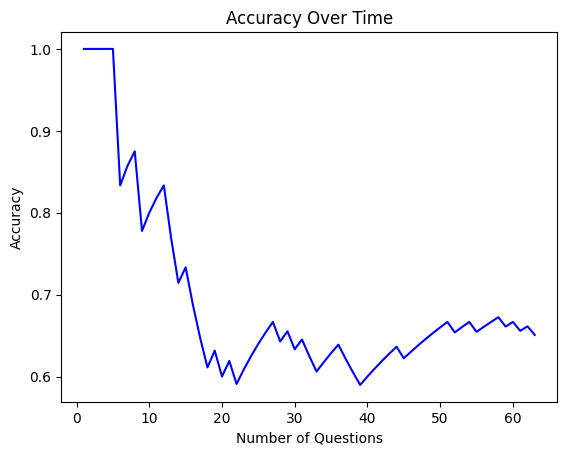

Processed 63/100 questions. Current accuracy: 65.08%


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.

KeyboardInterrupt



In [30]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# CollaborativeModel class
class CollaborativeModel:
    def __init__(self, model1, tokenizer1, model2, tokenizer2):
        self.model1 = model1
        self.tokenizer1 = tokenizer1
        
        self.model2 = model2
        self.tokenizer2 = tokenizer2

        self.device1 = torch.device("cuda")
        self.device2 = torch.device("cuda")

    def generate_response(self, model, tokenizer, prompt, device, max_length=1024):
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        outputs = model.generate(**inputs, max_new_tokens=max_length, num_return_sequences=1, 
                                 do_sample=False, temperature=0.0)
        
        # Exclude the prompt tokens from the generated output
        prompt_token_length = inputs['input_ids'].shape[1]
        return tokenizer.decode(outputs[0][prompt_token_length:], skip_special_tokens=True)

    def debate(self, question, num_rounds=2):
    #     # Initial instruction setup for both models
        discussion = f"""<|begin_of_text|><|start_header_id|>Instruction<|end_header_id|>
Llama will provide step-by-step answers to the given question, and EdgeRunner will provide different approaches, in order for both to converge to the correct solution.
The approaches have to have proper calculations, arithmetic and assumptions, in a clear and concise fashion.<|eot_id|>
In the end, Llama will correct and state the final answer as a single scalar value.<|start_header_id|>Question:<|end_header_id|>
{question}<|eot_id|>
<|start_header_id|>Answer:<|end_header_id|>"""
        # Llama's initial step
        prompt1 = f"{discussion}\nLlama:"# (Initial problem analysis and proposed solution):"
        response1 = self.generate_response(self.model1, self.tokenizer1, prompt1, self.device1)
        discussion += f"\nLlama: {response1.strip()}\n\n"

        for round in range(num_rounds):
            # EdgeRunner's critical evaluation and next step
            prompt2 = f"{discussion}\nEdgeRunner:"# (Critique and Next Step):\nLlama proposed the step above. Critically analyze it. If it's correct, provide the resulting solution. If it's incorrect, provide the correct step."
            response2 = self.generate_response(self.model2, self.tokenizer2, prompt2, self.device2)
            discussion += f"\nEdgeRunner: {response2.strip()}\n\n"

            # Llama's critique and next step
            prompt3 = f"{discussion}\nLlama:"# (Critique and Next Step):\nEdgeRunner proposed the step above. Critically analyze it. If it's correct, provide the resulting solution. If it's incorrect, provide the correct step."
            response3 = self.generate_response(self.model1, self.tokenizer1, prompt3, self.device1)
            discussion += f"\nLlama: {response3.strip()}\n\n"

        # Final answer synthesis
        final_prompt = f"{discussion}\nLlama (Final answer):\n"#Based on the critique and discussion above, Llama will now provide the final, verified answer as a single scalar value."
        final_answer = self.generate_response(self.model1, self.tokenizer1, final_prompt, self.device1, max_length=100)

        return discussion # final_answer

# Evaluation function
def evaluate_collaborative_model(model, dataset, num_samples=100, output_file="result.txt"):
    correct = 0
    total = 0
    
    accuracies = []
    
    plt.figure(figsize=(12, 6))
    
    with open(output_file, "a") as f:
        for i, example in enumerate(dataset.select(range(num_samples)), 1):
            torch.cuda.empty_cache()
            gc.collect()
            question = example['question']
            true_answer = example['answer']
            
            debate_result = model.debate(question)
            final_answer = clean_answer(debate_result)
            
            if clean_answer(true_answer) == final_answer:
                correct += 1
            total += 1
            
            current_accuracy = correct / total
            accuracies.append(current_accuracy)
            
            print(f"{debate_result}\n\n")
            f.write(f"Question {i}:\n{question}\n\n")
            f.write(f"Debate result:\n{debate_result}\n\n")
            f.write(f"True answer: {true_answer}\n")
            f.write(f"Final answer: {final_answer}\n")
            f.write(f"Current accuracy: {100*current_accuracy:.2f}%\n")
            f.write("-" * 50 + "\n\n")
            f.flush()
            
            # Clear the output and redraw the plot
            clear_output(wait=True)
            plt.clf()
            plt.plot(range(1, i+1), accuracies, 'b-')
            plt.title("Accuracy Over Time")
            plt.xlabel("Number of Questions")
            plt.ylabel("Accuracy")
            plt.show()
            # display(plt.gcf())
            print(f"Processed {i}/{num_samples} questions. Current accuracy: {100*current_accuracy:.2f}%")
    
    # Save the final plot
    plt.savefig("final_accuracy_plot.png")
    
    return correct / total

def clean_answer(text):
    # Remove commas from the text
    cleaned_text = text.replace(',', '')
    # Find all digit sequences in the cleaned text
    numbers = re.findall(r'\d+', cleaned_text)
    # Return the last number found, or None if no number is found
    return numbers[-1] if numbers else None


def parse_final_answer(evaluation):
    try:
        answer = evaluation.split('Final answer: ')[1]
        return clean_answer(answer)
    except:
        return 'NA' # Return NA if a final answer could not be found



# Load the GSM8K dataset
dataset = load_dataset("gsm8k", "main")

# Initialize the collaborative model (assuming model1, tokenizer1, model2, tokenizer2 are defined)
model = CollaborativeModel(model1, tokenizer1, model2, tokenizer2)

# Evaluate the collaborative model
accuracy = evaluate_collaborative_model(model, dataset["test"])
print(f"Final accuracy of the collaborative model: {accuracy:.2f}")